# Surprise Housing Assignment
## Author: Kumaraguru Muthuraj
### Problem Statement
#### Surprise Housing wants to buy low and sell high of properties in Australia.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, metrics
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

import os

# hide warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
housingDF = pd.read_csv("train.csv")

print(housingDF.shape)
housingDF.head()


(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
housingDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

##### MAKE ALL CAT VALUES lower case, Years many not be categorical, they are ordinal


In [4]:
housingDF.drop(['Id'], inplace=True, axis=1)

In [5]:
#Lowercase the category column values
def lowerCaseCategoryColumns(df):
    cols = df.select_dtypes(include=['object']).columns
    for col in cols:
        df[col] = df[col].str.lower()    
    return

#Check the nulls in categorical columns
def printCategoryColumnsPercentNNull(df):
    cols = df.select_dtypes(include=['object']).columns
    print("Category columns ", cols)
    print("Column count ", len(cols))

    colWithNull = 0
    for col in cols:
        total = df[col].size
        notNull = df[col].count()
        if  notNull != total:
            colWithNull += 1
            print('**********************')
            print('Column name ', col , '*** Percentage not null ', 100*notNull/total )
            print(' ')
            
    if colWithNull == 0:
        print("No columns have null values")

    return 

#Impute rest of the columns with 'None' for Nulls
def imputeCategoryColumnNullsWithNone(df):
    cols = df.select_dtypes(include=['object']).columns
    print("Category columns ", cols)
    print("Column count ", len(cols))
    
    for col in cols:
        total = df[col].size
        notNull = df[col].count()
        if  notNull != total:
            df[col] = df[col].fillna("none")
    return

def printNumericColsPercentNotNull(df):
    cols = df.select_dtypes(include=['int64', 'int32', 'float64']).columns
    print("Numerical columns ", cols)
    print("Column count ", len(cols))

    colWithNull = 0
    for col in cols:
        total = df[col].size
        notNull = df[col].count()
        if  notNull != total:
            colWithNull += 1
            print('**********************')
            print('Column name ', col , '*** Percentage not null ', 100*notNull/total )
            print(' ')
    
    if colWithNull == 0:
        print("No columns have null values")

    return 


#Impute numeric columns with 'Median' for Nulls
def imputeNumericColumnNullsWithMedian(df):
    cols = df.select_dtypes(include=['int64', 'int32', 'float64']).columns
    print("Numerical columns ", cols)
    print("Column count ", len(cols))
    
    for col in cols:
        total = df[col].size
        notNull = df[col].count()
        if  notNull != total:
            df[col] = df[col].fillna(df[col].median())
    return

def getLowerAndUpperFence(df, col):
    q1 = np.quantile(df[col], .25)
    q3 = np.quantile(df[col], .75)
    base = (q3 - q1) * 1.5
    lFen  = q1 - base
    uFen = q3 + base
    return (lFen, uFen)

def getPercentOfOutliers(df, col, l, u):
    lFilter = df[col] < l
    uFilter = df[col] > u
    
    low = df[lFilter] 
    high = df[uFilter]
    
    lPer = 100*len(low) / len(df)
    hPer = 100*len(high) / len(df)
    
    return (lPer, hPer)

#Util function to cap by k%
def capper(x, l, u):
    k = 5
    kpercent = (k / 100)
    if x < l:
        return (l - kpercent * (u - l))
    elif u < x:
        return (u + kpercent * (u - l))        
    return x

#Cap lower and upper limit
def capLowerAndUpperLimit(df, col, l, u):
    df[col] = df[col].apply(capper, args=(l, u))
    return

#Check outliers in numberic columns - print percent of 
#low and high outliers for each column
def checkOutliersInNumericColumns(df, cols):
    if len(cols) == 0:
        cols = df.select_dtypes(include=['int64', 'int32', 'float64']).columns
    
    print("Numerical columns ", cols)
    print("Column count ", len(cols))
    
    for col in cols:        
        plt.figure(figsize=(14, 5))

        plt.subplot(1,2,1)
        sns.boxplot(df[col])
        plt.title(col, fontsize=14)
        
        plt.subplot(1,2,2)
        plt.hist(df[col])
        plt.title(col, fontsize=14)
        
        plt.show()
        
        l, u = getLowerAndUpperFence(housingDF, col)
        lp, hp = getPercentOfOutliers(housingDF, col, l, u)
        
        print(col, " - Percent of outliers below lower fence ", lp, " and above upper fence ", hp)        
    return

#Pass a list of numeric column names that you want to cap up to k% of IQR
def capNumericColumnOutliers(df, cols):
    for col in cols:
        l, u = getLowerAndUpperFence(df, col)
        capLowerAndUpperLimit(df, col, l, u)
    return

# Importing the required libraries for plots.
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def residualAnalysis(yTrain, yTrainPred, logTxt):
    print(logTxt)
    # Plot the histogram of the error terms
    fig = plt.figure()
    fig.suptitle('Distribution of errors', fontsize = 12)
    res = (yTrain - yTrainPred)
    sns.distplot(res, bins = 20)
    plt.show()
    
    # Variance of error terms
    c = [i for i in range(1, len(res) + 1, 1)]
    plt.scatter(c, res)
    plt.title("Homoscedastic variance?", fontsize = 12)
    sns.regplot(x=c, y=res, line_kws={'color': 'yellow'})
    plt.show()
    
    plt.scatter(yTrainPred , res)
    plt.axhline(y=0, color='r', linestyle=':')
    plt.title("Pattern in residues?", fontsize = 12)
    plt.xlabel("Sales Price Predictions")
    plt.ylabel("Residual")
    plt.show()
    
    return

def predictAndDisplayScores(algorithm, XTrain, yTrain, XTest, yTest, logTxt):
    print(logTxt)

    print('**********XTrain columns ', len(XTrain.columns))
    print('**********XTest columns ', len(XTest.columns))
    
    results = {}
    yPredTrain = algorithm.predict(XTrain)
    yPredTest = algorithm.predict(XTest)

    results['YPredTrain'] = yPredTrain
    results['YPredTest'] = yPredTest
    
    metric = {}
    
    r2_train_lr = r2_score(yTrain, yPredTrain)
    metric['R2Train'] = r2_train_lr

    r2_test_lr = r2_score(yTest, yPredTest)
    metric['R2Test'] = r2_test_lr

    rss1_lr = np.sum(np.square(yTrain - yPredTrain))
    metric['RSSTrain'] = rss1_lr

    rss2_lr = np.sum(np.square(yTest - yPredTest))
    metric['RSSTest'] = rss2_lr

    mse_train_lr = mean_squared_error(yTrain, yPredTrain)
    RMSE_tr = mse_train_lr**0.5
    metric['MSETrain'] = mse_train_lr
    metric['RMSETrain'] = RMSE_tr

    mse_test_lr = mean_squared_error(yTest, yPredTest)
    RMSE_te = mse_test_lr**0.5
    metric['MSETest'] = mse_test_lr
    metric['RMSETest'] = RMSE_te
    
    results['metric'] = metric

    return results

def primitiveLRFitAndAnalyze(XTrain, yTrain, XTest, yTest):
    linearModel = LinearRegression()
    linearModel.fit(X_train, y_train)
    
    # TRAIN DATA PREDICTIONS
    # Making predictions
    yTrainPred = linearModel.predict(XTrain)
    
    # TRAIN DATA RESIDUAL ANALYSIS
    residualAnalysis(yTrain, yTrainPred, '***Linear regression training data residual analysis***')
    ##########################################
    
    # TEST DATA PREDICTIONS
    # Making predictions
    yTestPred = linearModel.predict(XTest)
    
    # Publish scores. Looks very good, but the difference in R2 between train and test is large
    results = predictAndDisplayScores(linearModel, XTrain, yTrain, XTest, yTest, \
                                      "****Scores of primitive Linear regression****")

    YPredTrain = results.get('YPredTrain') 
    YPredTest = results.get('YPredTest')
    metrics = results.get('metric')

    #print("Y Predicted train\n", YPredTrain)
    #print("Y Predicted test\n", YPredTest)
    print("Metrics\n", metrics)
    return linearModel

# Adding a constant variable 
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
def doRFEAndReturnTopVIFColumn(y_train, X_train_rfe):
    X_train_rfe = sm.add_constant(X_train_rfe)
    # Running the linear model
    lm = sm.OLS(y_train, X_train_rfe).fit()
    #Let's see the summary of our linear model
    print(lm.summary())
    
    # Calculate the VIFs for the new model
    vif = pd.DataFrame()
    X = X_train_rfe
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    
    pd.set_option('display.max_rows', None)
    print(vif)
    #If 'const' is top on list get next one
    colName = vif.iloc[0]['Features']
    if colName == 'const':
        colName = vif.iloc[1]['Features']
    return (colName, lm)

import statsmodels.api as statsModAPI
def LRFitAndAnalyze(XTrain, yTrain, XTest, yTest):    
    linearModel = LinearRegression()
    
    # Adding a constant variable 
    #XTrain = statsModAPI.add_constant(XTrain)
    linearModel.fit(XTrain, yTrain)
    
    # TRAIN DATA PREDICTIONS
    #X_train_no_const = X_train_rfe.drop(['const'], axis=1)
    # Making predictions
    yTrainPred = linearModel.predict(XTrain)
    
    # TRAIN DATA RESIDUAL ANALYSIS
    residualAnalysis(yTrain, yTrainPred, '***Linear regression training data residual analysis***')
    
    ##########################################
    
    # TEST DATA PREDICTIONS
    #X_train_no_const = X_train_rfe.drop(['const'], axis=1)

    # Adding a constant variable 
    #XTest = statsModAPI.add_constant(XTest)
    # Making predictions
    yTestPred = linearModel.predict(XTest)
    
    # TEST DATA RESIDUAL ANALYSIS
    residualAnalysis(yTest, yTestPred, '***Linear regression test data residual analysis***')
    
    # Publish scores. Looks very good, but the difference in R2 between train and test is large
    results = predictAndDisplayScores(linearModel, XTrain, yTrain, XTest, yTest, \
                                      "****Scores of Linear regression after RFE****")
    
    YPredTrain = results.get('YPredTrain') 
    YPredTest = results.get('YPredTest')
    metrics = results.get('metric')

    #print("Y Predicted train\n", YPredTrain)
    #print("Y Predicted test\n", YPredTest)
    print("Metrics\n", metrics)
    return linearModel

In [6]:
lowerCaseCategoryColumns(housingDF)
printCategoryColumnsPercentNNull(housingDF)

Category columns  Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')
Column count  43
**********************
Column name  Alley *** Percentage not null  6.232876712328767
 
**********************
Column name  MasVnrType *** Percentage not null  99.45205479452055
 
**********************
Column name  BsmtQual *** Percentage not null  97.46575342465754
 
**********************
Column n

In [7]:
housingDF[housingDF.select_dtypes(include=['object']).columns].head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,rl,pave,NaN,reg,lvl,allpub,inside,gtl,collgcr,norm,...,attchd,rfn,ta,ta,y,NaN,NaN,NaN,wd,normal
1,rl,pave,NaN,reg,lvl,allpub,fr2,gtl,veenker,feedr,...,attchd,rfn,ta,ta,y,NaN,NaN,NaN,wd,normal
2,rl,pave,NaN,ir1,lvl,allpub,inside,gtl,collgcr,norm,...,attchd,rfn,ta,ta,y,NaN,NaN,NaN,wd,normal
3,rl,pave,NaN,ir1,lvl,allpub,corner,gtl,crawfor,norm,...,detchd,unf,ta,ta,y,NaN,NaN,NaN,wd,abnorml
4,rl,pave,NaN,ir1,lvl,allpub,fr2,gtl,noridge,norm,...,attchd,rfn,ta,ta,y,NaN,NaN,NaN,wd,normal


In [8]:
#Drop 'Alley', 'PoolQC' and 'MiscFeature' column because they have very high null values
dropNullValCols = ['Alley', 'PoolQC', 'MiscFeature']
housingDF.drop(dropNullValCols, inplace=True, axis=1)
#Impute nulls and check for nulls
imputeCategoryColumnNullsWithNone(housingDF)
printCategoryColumnsPercentNNull(housingDF)

Category columns  Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'Fence', 'SaleType', 'SaleCondition'],
      dtype='object')
Column count  40
Category columns  Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond

In [9]:
printNumericColsPercentNotNull(housingDF)
imputeNumericColumnNullsWithMedian(housingDF)

Numerical columns  Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')
Column count  37
**********************
Column name  LotFrontage *** Percentage not null  82.26027397260275
 
**********************
Column name  MasVnrArea *** Percentage not null  99.45205479452055
 
**********************
Column name  GarageYrBlt *** Percentage not null  94.45205479452055
 
Numerical columns  Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond'

In [10]:
#Convert year and month fields to int to avoid decimal places
housingDF.YearBuilt = housingDF.YearBuilt.astype('int')
housingDF.YearRemodAdd = housingDF.YearRemodAdd.astype('int')
housingDF.MoSold = housingDF.MoSold.astype('int')
housingDF.YrSold = housingDF.YrSold.astype('int')
housingDF.GarageYrBlt = housingDF.GarageYrBlt.astype('int')

In [11]:
printNumericColsPercentNotNull(housingDF)

Numerical columns  Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')
Column count  37
No columns have null values


Numerical columns  Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')
Column count  37


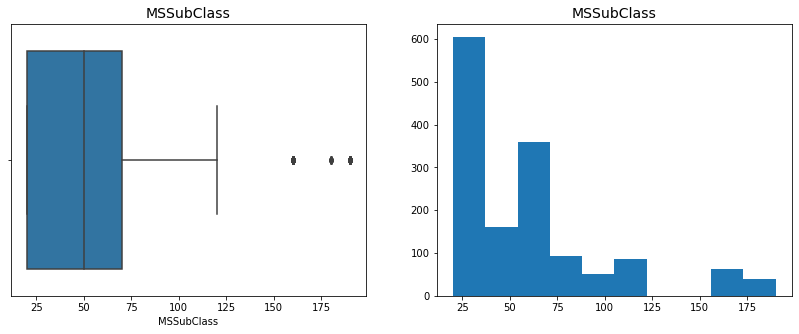

MSSubClass  - Percent of outliers below lower fence  0.0  and above upper fence  7.054794520547945


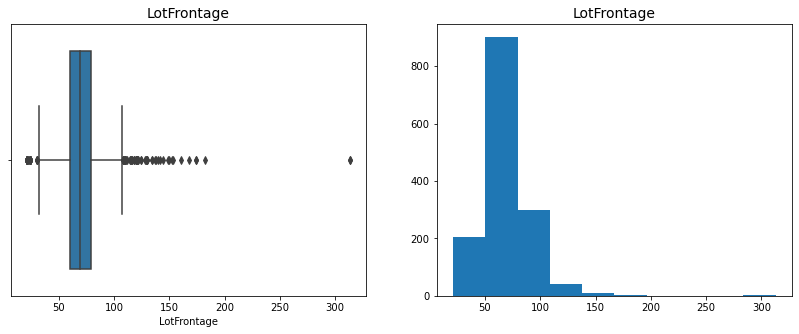

LotFrontage  - Percent of outliers below lower fence  3.287671232876712  and above upper fence  3.9726027397260273


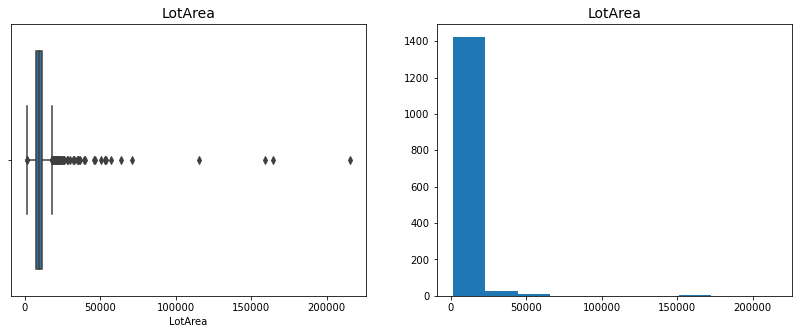

LotArea  - Percent of outliers below lower fence  0.136986301369863  and above upper fence  4.589041095890411


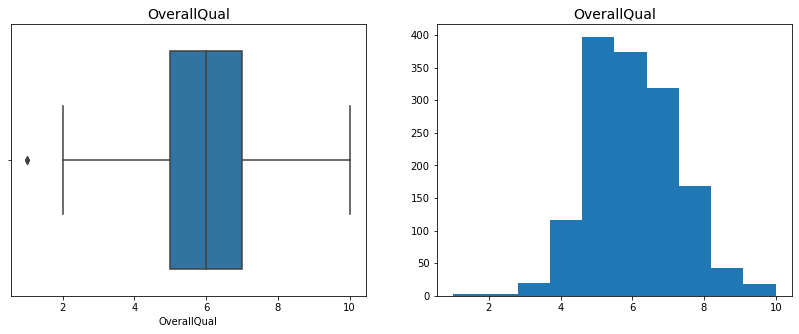

OverallQual  - Percent of outliers below lower fence  0.136986301369863  and above upper fence  0.0


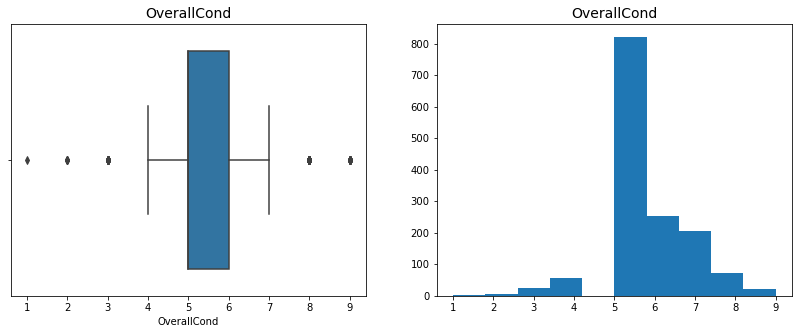

OverallCond  - Percent of outliers below lower fence  2.1232876712328768  and above upper fence  6.438356164383562


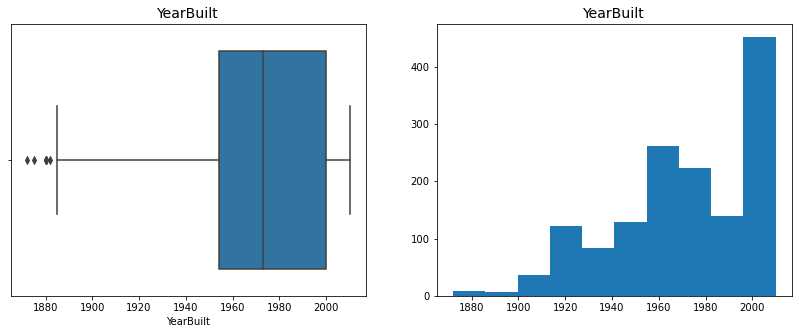

YearBuilt  - Percent of outliers below lower fence  0.4794520547945205  and above upper fence  0.0


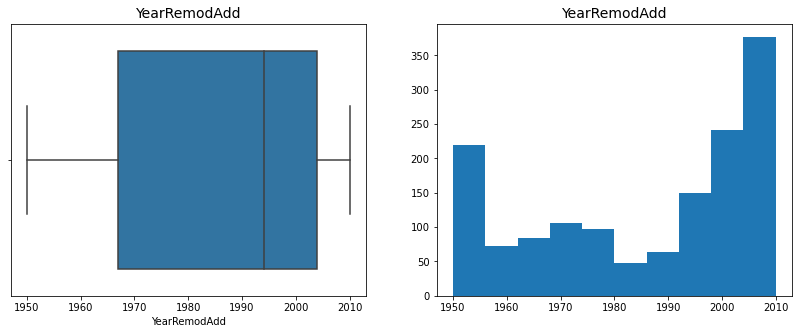

YearRemodAdd  - Percent of outliers below lower fence  0.0  and above upper fence  0.0


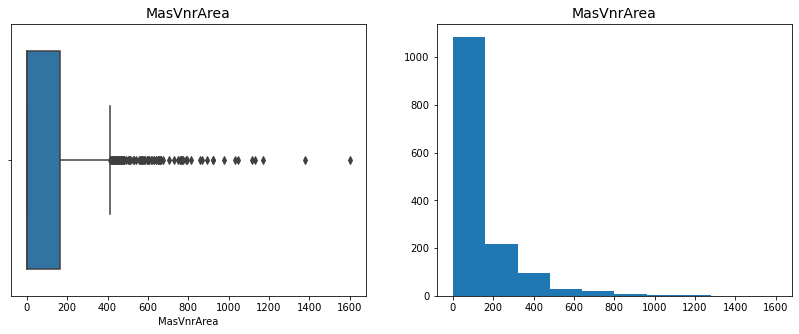

MasVnrArea  - Percent of outliers below lower fence  0.0  and above upper fence  6.712328767123288


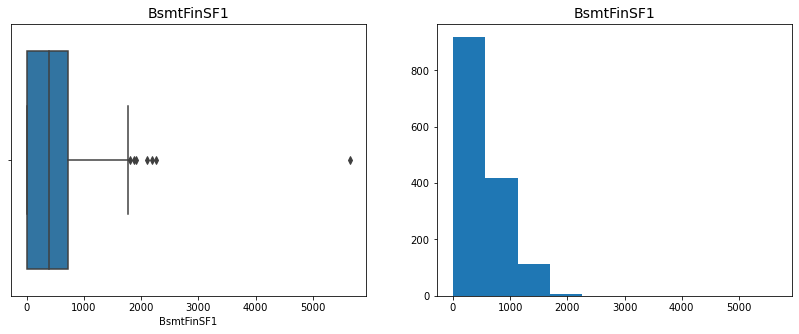

BsmtFinSF1  - Percent of outliers below lower fence  0.0  and above upper fence  0.4794520547945205


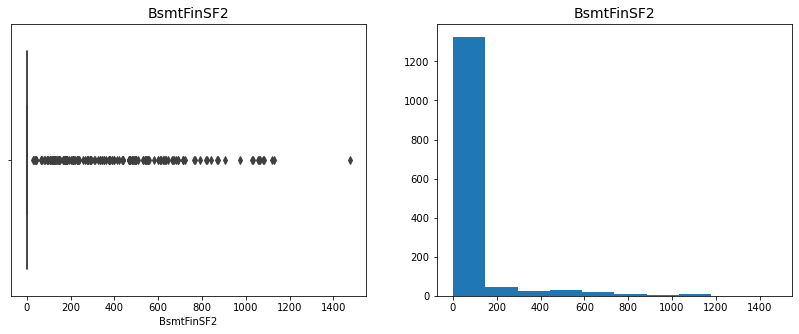

BsmtFinSF2  - Percent of outliers below lower fence  0.0  and above upper fence  11.438356164383562


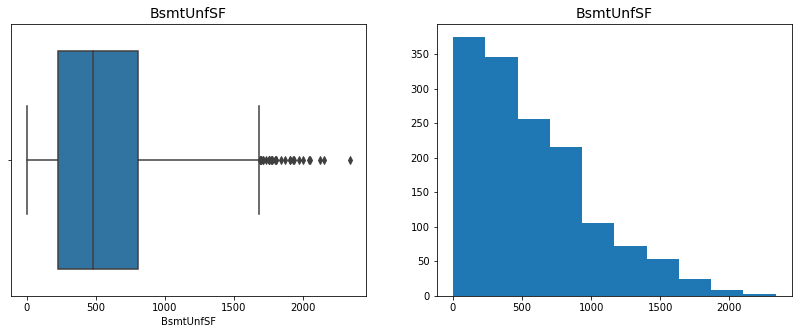

BsmtUnfSF  - Percent of outliers below lower fence  0.0  and above upper fence  1.9863013698630136


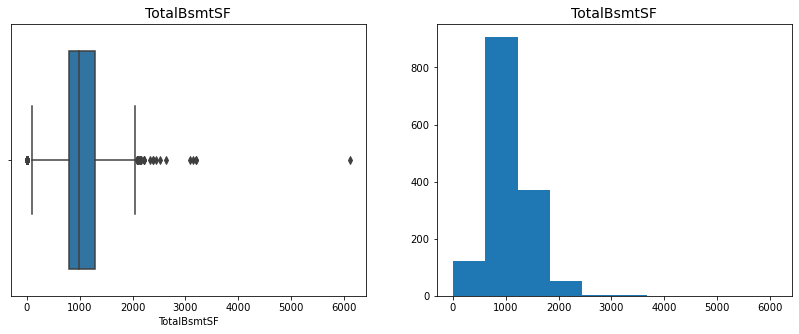

TotalBsmtSF  - Percent of outliers below lower fence  2.5342465753424657  and above upper fence  1.643835616438356


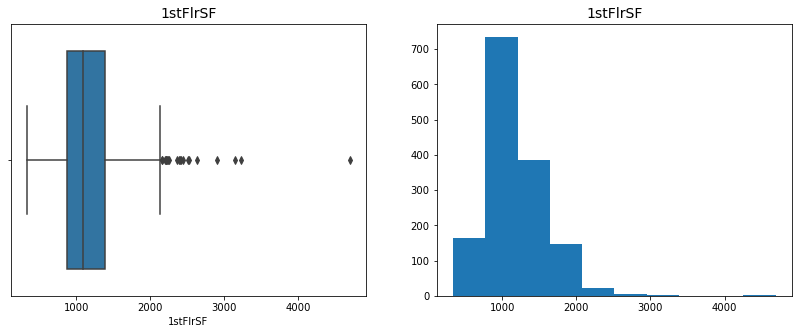

1stFlrSF  - Percent of outliers below lower fence  0.0  and above upper fence  1.36986301369863


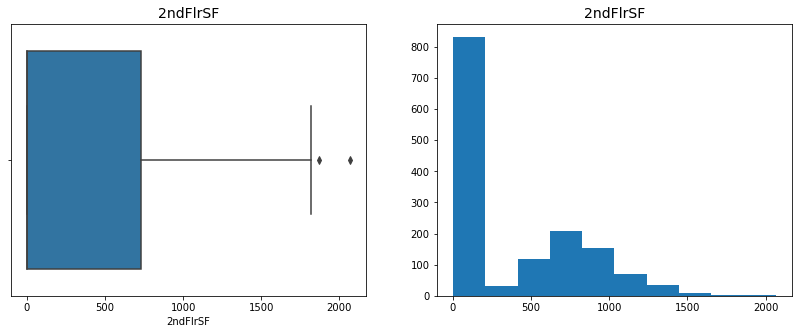

2ndFlrSF  - Percent of outliers below lower fence  0.0  and above upper fence  0.136986301369863


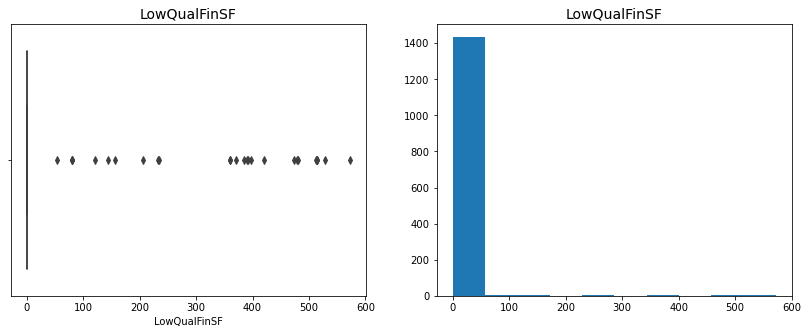

LowQualFinSF  - Percent of outliers below lower fence  0.0  and above upper fence  1.7808219178082192


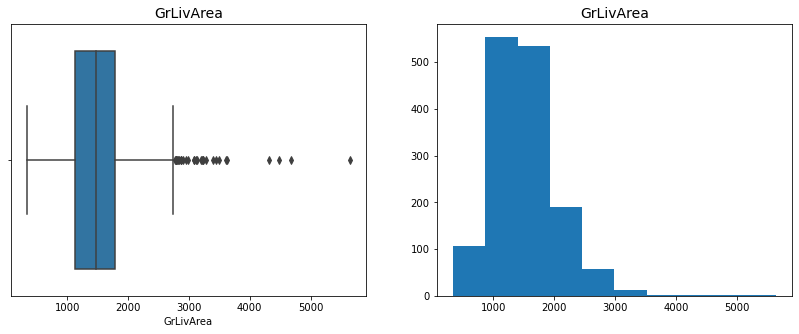

GrLivArea  - Percent of outliers below lower fence  0.0  and above upper fence  2.1232876712328768


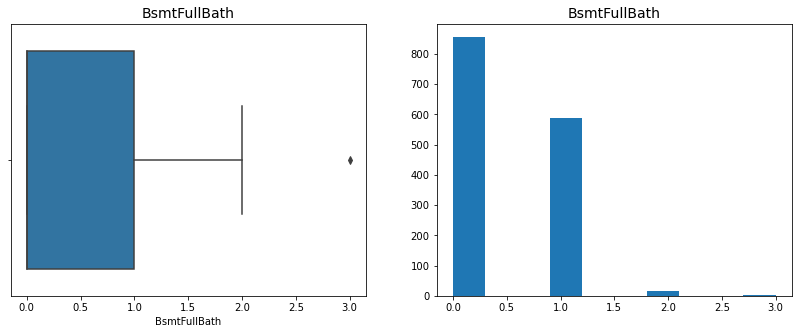

BsmtFullBath  - Percent of outliers below lower fence  0.0  and above upper fence  0.0684931506849315


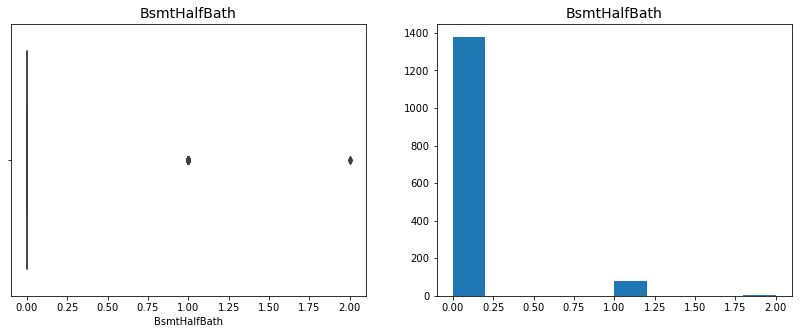

BsmtHalfBath  - Percent of outliers below lower fence  0.0  and above upper fence  5.616438356164384


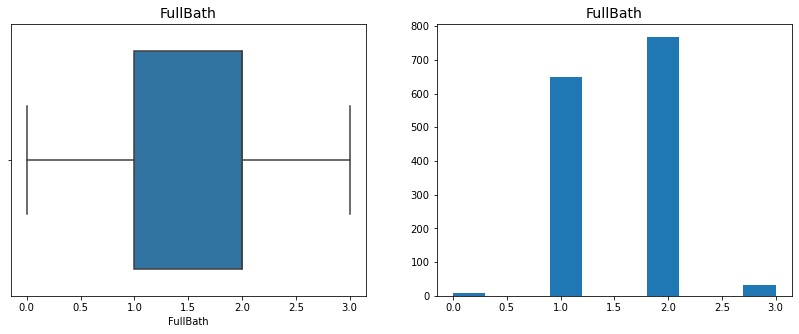

FullBath  - Percent of outliers below lower fence  0.0  and above upper fence  0.0


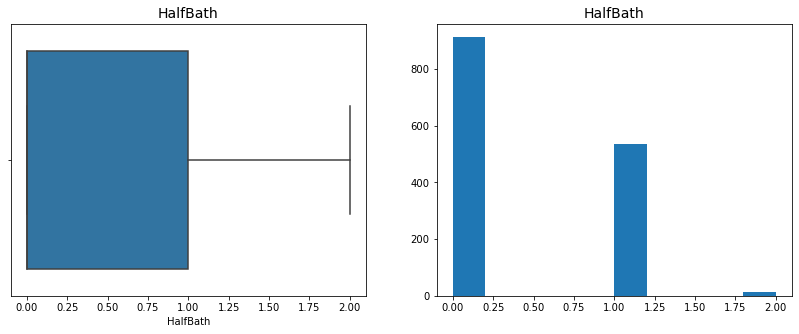

HalfBath  - Percent of outliers below lower fence  0.0  and above upper fence  0.0


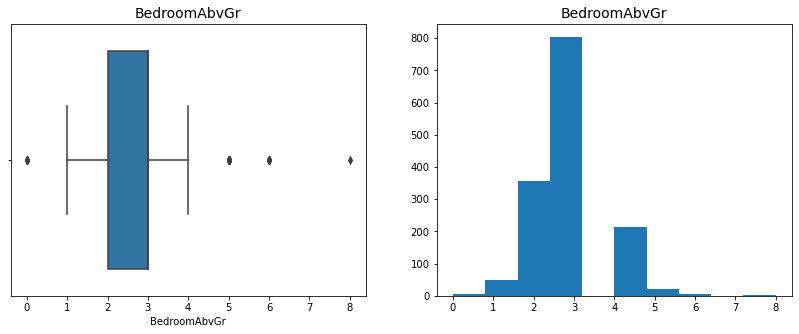

BedroomAbvGr  - Percent of outliers below lower fence  0.410958904109589  and above upper fence  1.9863013698630136


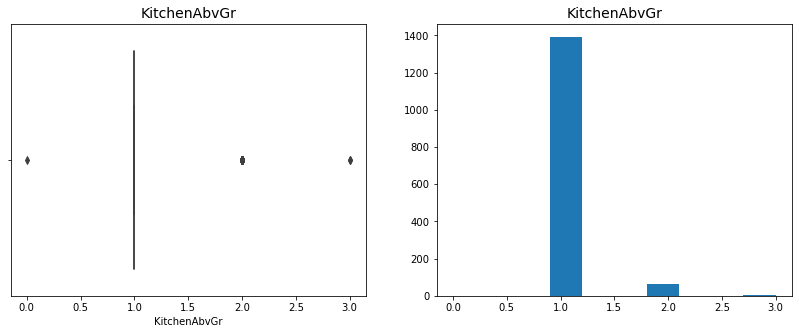

KitchenAbvGr  - Percent of outliers below lower fence  0.0684931506849315  and above upper fence  4.589041095890411


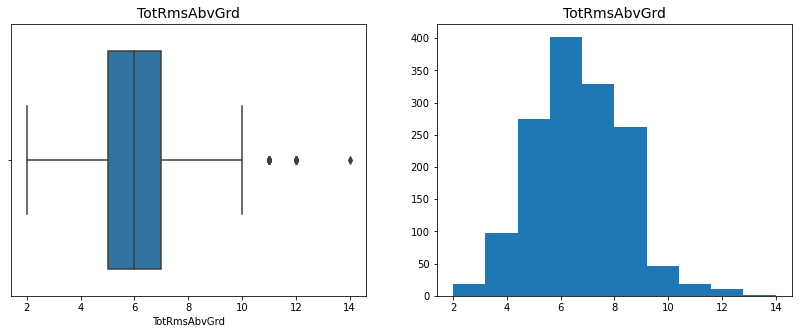

TotRmsAbvGrd  - Percent of outliers below lower fence  0.0  and above upper fence  2.0547945205479454


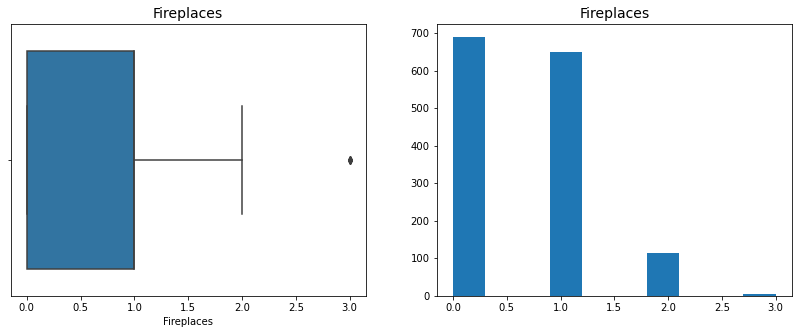

Fireplaces  - Percent of outliers below lower fence  0.0  and above upper fence  0.3424657534246575


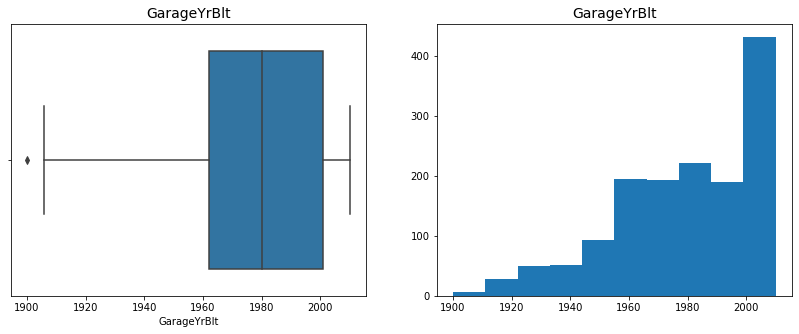

GarageYrBlt  - Percent of outliers below lower fence  0.0684931506849315  and above upper fence  0.0


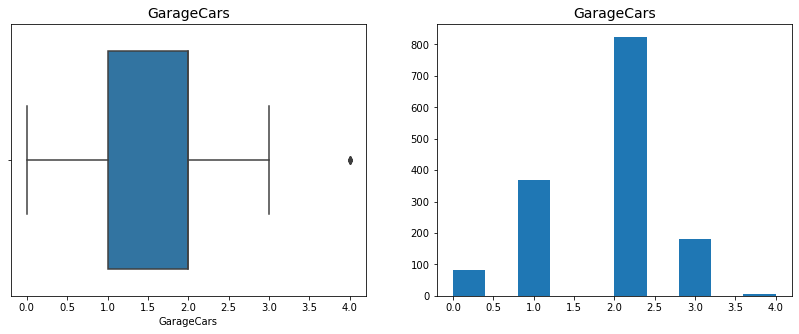

GarageCars  - Percent of outliers below lower fence  0.0  and above upper fence  0.3424657534246575


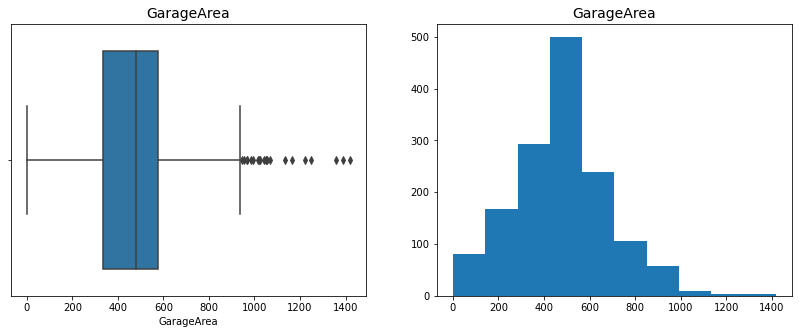

In [ ]:
checkOutliersInNumericColumns(housingDF, [])

In [ ]:
#Columns that had a very high repetition of values and indicated by the histogram and box plot with IQR appearing
#as vertical line are to be removed. They have no impact on sale price.
dropColumns = ['LotArea', 'BsmtFinSF2', 'LowQualFinSF', 'BsmtHalfBath', 'KitchenAbvGr', 'EnclosedPorch', \
               '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']

housingDF.drop(dropColumns, inplace=True, axis=1)

In [ ]:
columnsToCap = ['MSSubClass', 'LotFrontage', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', \
                'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',\
                'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd',\
                'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',\
                'OpenPorchSF',  'MoSold', 'YrSold']

capNumericColumnOutliers(housingDF, columnsToCap)

In [ ]:
checkOutliersInNumericColumns(housingDF, columnsToCap)

In [ ]:
#Get all numeric columns to apply MinMax Scaler
#This is only for scaling purpose and for nothing else
tDF = housingDF.select_dtypes(include=['int32', 'int64', 'float64'])
numericCols2Scale = list(tDF.columns)

In [ ]:
category_cols = housingDF.select_dtypes(include=['object']).columns
dummyCols = pd.get_dummies(housingDF[category_cols], drop_first = True)

housingDF = pd.concat([housingDF, dummyCols], axis = 1)
housingDF.drop(list(category_cols), axis = 1, inplace = True)

In [ ]:
housingDF.columns

####  Split train and test

In [ ]:
from sklearn.model_selection import train_test_split

# We specify this so that the train and test data set always have the same rows, respectively
np.random.seed(0)
df_train, df_test = train_test_split(housingDF, train_size = 0.7, test_size = 0.3, random_state = 100)

#### Apply MinMaxScaler to all the numeric variables

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# Apply scaler() to all the Feature - X vars (that are numeric)
#Train data scaling
df_train[numericCols2Scale] = scaler.fit_transform(df_train[numericCols2Scale])
#Test data scaling
df_test[numericCols2Scale] = scaler.transform(df_test[numericCols2Scale])

In [ ]:
#Separate train data features and target (X and y)
y_train = df_train.pop('SalePrice')
X_train = df_train

#Separate test data features and target (X and y)
y_test = df_test.pop('SalePrice')
X_test = df_test

In [ ]:
df_train.head()

In [ ]:
X_train.columns

 #### Linear Regression - BEGIN - From Car price file

In [ ]:
# Instantiate and fit a line
primLM = primitiveLRFitAndAnalyze(X_train, y_train, X_test, y_test)

In [ ]:
# Print the coefficients and intercept
print(primLM.intercept_)
print(primLM.coef_)

#### Predict for train and test and compare the scores

#### Linear Regression - END - From Car price file

#### Linear Regression with RFE

In [ ]:
# Running RFE with the output number of the variable equal to 10
rfeLM = LinearRegression()
rfeLM.fit(X_train, y_train)

TOP_N_COLUMNS = 40
rfe = RFE(rfeLM, TOP_N_COLUMNS)
rfe = rfe.fit(X_train, y_train)

In [ ]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

In [ ]:
#There are TOP_N_COLUMNS columns that RFE has 'favourably' supported.
col = X_train.columns[rfe.support_]
col

In [ ]:
#X_train.columns[~rfe.support_]

### Building model using statsmodel, for the detailed statistics

In [ ]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

In [ ]:
dropColumns = []

In [ ]:
#REMOVE top VIF columns iteratively
X_train_rfe = X_train_rfe.drop(dropColumns, axis = 1)
toDelColumn, rfeLM = doRFEAndReturnTopVIFColumn(y_train, X_train_rfe)
dropColumns = [toDelColumn]
print('**** Feature with TOP VIF is ', toDelColumn, ' ****')
print('**** To drop ', toDelColumn, ' and do VIF run this cell again ***')

In [ ]:
print(X_train_rfe.columns)
print(len(X_train_rfe.columns))

In [ ]:
X_train = X_train[X_train_rfe.columns]
X_test = X_test[X_train_rfe.columns]

postRFELM = LRFitAndAnalyze(X_train, y_train, X_test, y_test)

## Ridge Regression

In [ ]:
# list of alphas to tune - if value too high it will lead to underfitting, if it is too low, 
# it will not handle the overfitting
params = {'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1, 
                     0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.5, 
                     1.9997, 1.9998, 1.9999, 2.0, 2.1111, 2.1112, 2.1113, 2.5, 3.0, 
                     4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 
#https://scikit-learn.org/stable/modules/model_evaluation.html


In [ ]:
# Printing the best hyperparameter alpha
ridgeAlpha = model_cv.best_params_.get('alpha')
print('Ridge Regularization Alpha - ',  ridgeAlpha)

In [ ]:
def ridgeFitAndAnalyze(alpha, XTrain, yTrain, XTest, yTest):
    #Fitting Ridge model for alpha and printing coefficients which have been penalised
    print("Ridge alpha - ", alpha)
    ridge = Ridge(alpha = alpha)
    ridge.fit(XTrain, yTrain)
    print(ridge.coef_)
    print(len(ridge.coef_))
    
    results = predictAndDisplayScores(ridge, XTrain, yTrain, XTest, yTest, "****Scores of Ridge regularization****")

    YPredTrain = results.get('YPredTrain')
    YPredTest = results.get('YPredTest')
    metrics = results.get('metric')

    #print("Y Predicted train\n", YPredTrain)
    #print("Y Predicted test\n", YPredTest)
    print("Metrics\n", metrics)
    
    residualAnalysis(yTrain, YPredTrain, '***Ridge regularization residual analysis***')

    return ridge

In [ ]:
ridgeModel = ridgeFitAndAnalyze(ridgeAlpha, X_train, y_train, X_test, y_test)

### Lasso Regression

In [ ]:
params = {'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1, 
                     0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
                     4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

lasso = Lasso()
# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train)

In [ ]:
# Printing the best hyperparameter alpha
lassoAlpha = model_cv.best_params_.get('alpha')
print('Lasso Regularization Alpha - ', lassoAlpha)

In [ ]:
def lassoFitAndAnalyze(alpha, XTrain, yTrain, XTest, yTest):
    #Fitting Ridge model for alpha = 100 and printing coefficients which have been penalised
    print("Lasso alpha - ", alpha)
    lasso = Lasso(alpha=alpha)
    lasso.fit(XTrain, yTrain)
    
    print('Number of features selected ', np.count_nonzero(lasso.coef_))
    
    results = predictAndDisplayScores(lasso, XTrain, yTrain, XTest, yTest, "****Scores of Lasso regularization****")

    YPredTrain = results.get('YPredTrain')
    YPredTest = results.get('YPredTest')
    metrics = results.get('metric')

    #print("Y Predicted train\n", YPredTrain)
    #print("Y Predicted test\n", YPredTest)
    print("Metrics\n", metrics)
    
    residualAnalysis(y_train, YPredTrain, '***Lasso regularization residual analysis***')
    
    return lasso

In [ ]:
lassoModel = lassoFitAndAnalyze(lassoAlpha, X_train, y_train, X_test, y_test)

In [ ]:
def getBetas(XTrain, linMod, ridMod, lasMod):
    betas = pd.DataFrame(index = XTrain.columns)
    betas.rows = XTrain.columns

    betas['Linear'] = linMod.coef_
    betas['Ridge'] = ridMod.coef_
    betas['Lasso'] = lasMod.coef_
    return betas


In [ ]:
betas = getBetas(X_train, postRFELM, ridgeModel ,lassoModel)
pd.set_option('display.max_rows', None)
betas.head(200)

In [ ]:
#Top 5 coeffs in each
#Improvement areas
#Results
#Conclusion

In [ ]:
def getTopBetas(betas):
    #Get the magnitude of the betas
    for col in betas.columns:
        betas[col] = betas[col].apply(abs)
    #Sort the features based on betas for each algorithm
    for col in betas.columns:
        print("****Printing by ", col, "****")
        betas = betas.sort_values(by=[col], ascending=False)
        print(betas[col].iloc[0:5])    
    return

In [ ]:
getTopBetas(betas)

### Answers to questions in assignment part I
- ### Q1) Which variables are significant in predicting the price of a house?

#### The TOP 5 features impacting sales price by each algorithm (decided by the magnitude of the betas)
Linear Regression - 'R2Train': 0.92, 'R2Test': 0.81
- RoofMatl_membran    0.619758
- Condition2_posn     -0.571398
- RoofMatl_wdshngl    0.552684
- RoofMatl_metal      0.513750
- RoofMatl_roll       0.511392

Ridge Regularization - 'R2Train': 0.89, 'R2Test': 0.86, Best lambda - 1.5
- Condition2_posn     -0.176019
- 2ndFlrSF            0.123256
- 1stFlrSF            0.119751
- OverallQual         0.113508
- RoofMatl_wdshngl    0.098919

Lasso Regularization - 'R2Train': 0.90, 'R2Test': 0.84, Best lambda - 0.0001
- Condition2_posn    -0.365658
- 2ndFlrSF           0.170472
- 1stFlrSF           0.166152
- OverallQual        0.125641
- YearBuilt          0.087396

- ### Q2) How well those variables describe the price of a house?
- These are the variables that were arrived after applying RFE in Linear Regression, Ridge and Lasso Regularizations. 
- The R2 values for the 3 algorithms are listed above. Notice that these are pretty close ~5%, except for Linear Regression. LR accuracy was low due to the variance and we had to reduce it with regularization. 
- The Regularization algorithms have given reasonable accuracies in test data. The residual analysis for the 3 algorithms indicate homoscedasticity, no patterns in errors, errors are normally distributed around 0.

- ### Q3) Lambda for Ridge and Lasso - The lambdas for Ridge and Lasso are 1.5 and 0.0001 respectively.



### Code for questions in assignment part II

### Q1) What is the impact on top features if alpha is doubled for Ridge and Lasso?

In [ ]:
ridgeModel2 = ridgeFitAndAnalyze(ridgeAlpha*2, X_train, y_train, X_test, y_test)

In [ ]:
lassoModel2 = lassoFitAndAnalyze(lassoAlpha*2, X_train, y_train, X_test, y_test)

In [ ]:
betas = getBetas(X_train, postRFELM, ridgeModel2 ,lassoModel2)
pd.set_option('display.max_rows', None)
betas.head(200)
getTopBetas(betas)

### Q3) What if top 5 features are missing in the data? 
#### We remove the features in test and train data, rebuild the RFE Linear model, regularize with Lasso and then pick the top 5 features.

In [ ]:
from sklearn.model_selection import train_test_split

#Top 5 from Lasso model
removeCols = ['Condition2_posn', '1stFlrSF', '2ndFlrSF','OverallQual', 'YearBuilt']
housingDF.drop(removeCols, inplace=True, axis=1)

In [ ]:
# We specify this so that the train and test data set always have the same rows, respectively
np.random.seed(0)
df_train, df_test = train_test_split(housingDF, train_size = 0.7, test_size = 0.3, random_state = 100)

numericCols2Scale = list(set(numericCols2Scale).difference(set(removeCols)))

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# Apply scaler() to all the Feature - X vars (that are numeric)
#Train data scaling
df_train[numericCols2Scale] = scaler.fit_transform(df_train[numericCols2Scale])
#Test data scaling
df_test[numericCols2Scale] = scaler.transform(df_test[numericCols2Scale])

#Separate train data features and target (X and y)
y_train = df_train.pop('SalePrice')
X_train = df_train

#Separate test data features and target (X and y)
y_test = df_test.pop('SalePrice')
X_test = df_test

In [ ]:
# Running RFE with the output number of the variable equal to 10
rfeLM = LinearRegression()
rfeLM.fit(X_train, y_train)

TOP_N_COLUMNS = 40
rfe = RFE(rfeLM, TOP_N_COLUMNS)
rfe = rfe.fit(X_train, y_train)

list(zip(X_train.columns,rfe.support_,rfe.ranking_))

#There are TOP_N_COLUMNS columns that RFE has 'favourably' supported.
col = X_train.columns[rfe.support_]
col

# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

In [ ]:
dropColumns = []

In [ ]:
#REMOVE top VIF columns iteratively
X_train_rfe = X_train_rfe.drop(dropColumns, axis = 1)
toDelColumn, rfeLM = doRFEAndReturnTopVIFColumn(y_train, X_train_rfe)
dropColumns = [toDelColumn]
print('**** Feature with TOP VIF is ', toDelColumn, ' ****')
print('**** To drop ', toDelColumn, ' and do VIF run this cell again ***')

In [ ]:
print(X_train_rfe.columns)
print(len(X_train_rfe.columns))

X_train = X_train[X_train_rfe.columns]
X_test = X_test[X_train_rfe.columns]

In [ ]:
postRFELM = LRFitAndAnalyze(X_train, y_train, X_test, y_test)

In [ ]:
params = {'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1, 
                     0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
                     4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

lasso = Lasso()
# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train)

# Printing the best hyperparameter alpha
lassoAlpha = model_cv.best_params_.get('alpha')
print('Lasso Regularization Alpha - ', lassoAlpha)


lassoModel = lassoFitAndAnalyze(lassoAlpha, X_train, y_train, X_test, y_test)

In [ ]:
betas = pd.DataFrame(index = X_train.columns)
betas.rows = X_train.columns

betas['Lasso'] = lassoModel.coef_
pd.set_option('display.max_rows', None)
betas.head(200)


In [ ]:
getTopBetas(betas)